In [1]:
required_packages <- c(
  "forecast",       # ARIMAX modeling
  "dplyr",          # Data manipulation
  "tidyr",          # pivot_wider/pivot_longer
  "prophet",        # xreg forecasting
  "thief",          # h
  "TSrepr",         # Errors
  "ggplot2",
  "stringr"
)

# Install missing packages
new_packages <- required_packages[!required_packages %in% installed.packages()[,"Package"]]
if(length(new_packages)) install.packages(new_packages)

# Load all packages
invisible(lapply(required_packages, library, character.only = TRUE))

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Rcpp

Loading required package: rlang



In [2]:
# Parametrai
stockout_cost <- 10
overstock_cost <- 1

In [3]:
# Įkeliami failai
train <- read.csv("sales_train_validation.csv")
test <- read.csv("sales_test_validation.csv")
arimax <- read.csv("submission_arimax9.csv")
ets <- read.csv("PF_ES_bu.csv")

In [4]:
# Nustatoma serija
store_id <- "CA_1"
dept_id <- "FOODS_1"

In [8]:
# Tikros testavimo reikšmės
true_test <- test %>%
  filter(store_id == "CA_1", dept_id == "FOODS_1") %>%
  select(starts_with("d_")) %>%
  colSums()

In [9]:
# ARIMAX prognozės
arimax_fc <- arimax %>%
  filter(store_id == "CA_1", dept_id == "FOODS_1") %>%
  select(starts_with("F")) %>%
  as.numeric()

In [12]:
# ETS prognozės
ets_fc <- ets %>%
  mutate(
    dept_id = str_extract(id, "^[^_]+_[^_]+"),
    store_id = str_extract(id, "(?<=_[A-Z]{2}_)CA_\\d|TX_\\d|WI_\\d|CA_1|TX_2|WI_3")
  ) %>%
  filter(dept_id == "FOODS_1", store_id == "CA_1") %>%
  select(starts_with("F")) %>%
  summarise(across(everything(), sum, na.rm = TRUE)) %>%
  as.numeric()

In [14]:
# Funkcija skaičiuoti kaštus
calc_costs <- function(pred, true) {
  over <- ifelse(pred > true, pred - true, 0)
  under <- ifelse(pred < true, true - pred, 0)
  over * overstock_cost + under * stockout_cost
}

In [15]:
# Apskaičiuojami nuostoliai
loss_arimax <- calc_costs(arimax_fc, true_test)
loss_ets <- calc_costs(ets_fc, true_test)

In [16]:
# Datos
dates <- seq(as.Date("2016-04-25"), by = "day", length.out = 28)

In [21]:
# Sudaromas grafiko duomenų rėmelis
loss_df <- data.frame(
  date = rep(dates, 2),
  model = rep(c("ARIMAX", "ETS_bu"), each = 28),
  loss = c(loss_arimax, loss_ets)
)

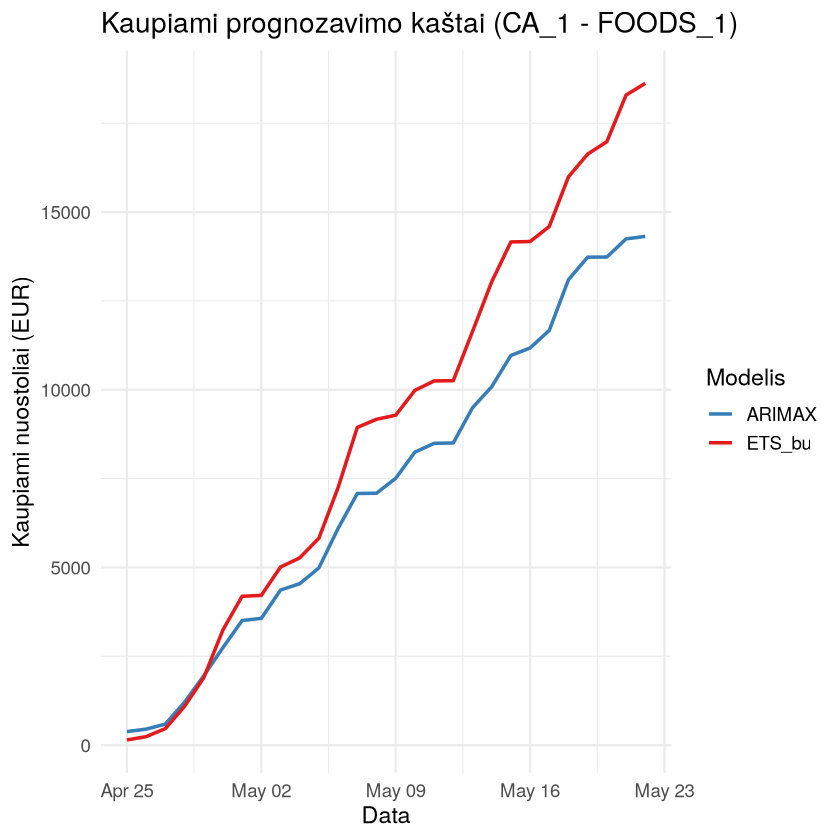

In [27]:
loss_df %>%
  group_by(model) %>%
  arrange(date) %>%
  mutate(cum_loss = cumsum(loss)) %>%
  ggplot(aes(x = date, y = cum_loss, color = model)) +
  geom_line(linewidth = 1) +
  labs(
    title = paste("Kaupiami prognozavimo kaštai (", store_id, " - ", dept_id, ")", sep = ""),
    x = "Data",
    y = "Kaupiami nuostoliai (EUR)",
    color = "Modelis"
  ) +
  scale_color_manual(values = c("ARIMAX" = "#377eb8", "ETS_bu" = "#e41a1c")) +
  theme_minimal(base_size = 14)

In [28]:
ggsave("prognozavimo_kastai.png", width = 8, height = 5, dpi = 300)

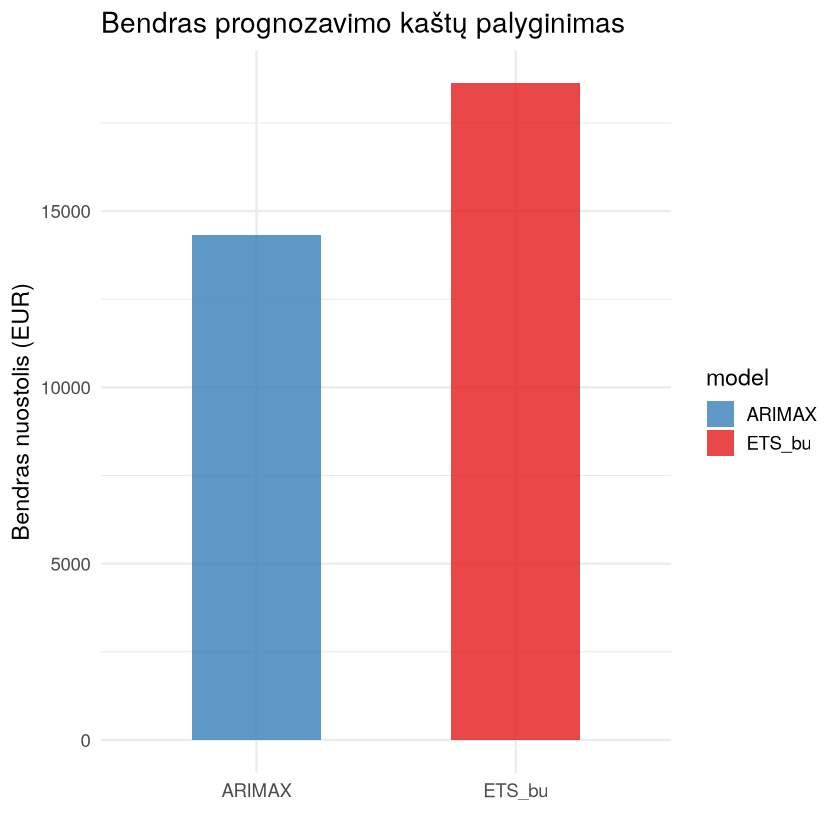

In [23]:
loss_summary <- loss_df %>%
  group_by(model) %>%
  summarise(total_loss = sum(loss))

ggplot(loss_summary, aes(x = model, y = total_loss, fill = model)) +
  geom_col(alpha = 0.8, width = 0.5) +
  labs(
    title = "Bendras prognozavimo kaštų palyginimas",
    y = "Bendras nuostolis (EUR)",
    x = ""
  ) +
  scale_fill_manual(values = c("ARIMAX" = "#377eb8", "ETS_bu" = "#e41a1c")) +
  theme_minimal(base_size = 14)